In [1]:
!pip install medmnist

In [2]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torch.utils.data as data
import torchvision.transforms as transforms
import torch.nn.functional as F
from sklearn import metrics

import medmnist
from medmnist import INFO, Evaluator

In [3]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v3.0.1 @ https://github.com/MedMNIST/MedMNIST/


In [32]:
data_flag = 'breastmnist'
download = True

NUM_EPOCHS = 20
BATCH_SIZE = 100
LEARNING_RATES = [0.0005, 0.001, 0.01]
MOMENTUM_VALUES = [0.9, 0.95, 0.99]
WEIGHT_DECAYS = [0.0001, 0.001, 0.01, 0.1]
RANDOM_SEARCH_TRIALS = 5
1
info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

print("CHANNELS:", n_channels)
print("CLASSES:", n_classes)

DataClass = getattr(medmnist, info['python_class'])
print(DataClass)

CHANNELS: 1
CLASSES: 2
<class 'medmnist.dataset.BreastMNIST'>


In [33]:
def get_device():
    return "cuda" if torch.cuda.is_available() else "cpu"

device = get_device()
print(device)

cuda


## First, we read the MedMNIST data, preprocess them and encapsulate them into dataloader form.

In [34]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    # transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

validation_transform = transforms.Compose([
    transforms.Resize((128, 128)), # (224, 224)),  # Resize for consistency
    #transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])



# Load the original dataset
original_dataset = medmnist.dataset.BreastMNIST(split='train', transform=data_transform, download=download)


# # Calculate the sizes for training and validation sets
# total_size = len(original_dataset)
# train_size = int(0.8 * total_size)
# val_size = total_size - train_size

# Split the dataset into training and validation sets
# train_dataset, validation_dataset = data.random_split(original_dataset, [train_size, val_size])


# # load the data
train_dataset = DataClass(split='train', transform=train_transform, download=download)
validation_dataset = DataClass(split='val', transform=validation_transform, download=download)
test_dataset = DataClass(split='test', transform=test_transform, download=download)
pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = data.DataLoader(dataset=validation_dataset, batch_size=BATCH_SIZE, shuffle=False)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Using downloaded and verified file: C:\Users\zayaa\.medmnist\breastmnist.npz
Using downloaded and verified file: C:\Users\zayaa\.medmnist\breastmnist.npz
Using downloaded and verified file: C:\Users\zayaa\.medmnist\breastmnist.npz
Using downloaded and verified file: C:\Users\zayaa\.medmnist\breastmnist.npz
Using downloaded and verified file: C:\Users\zayaa\.medmnist\breastmnist.npz


In [35]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset BreastMNIST of size 28 (breastmnist)
    Number of datapoints: 546
    Root location: C:\Users\zayaa\.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'malignant', '1': 'normal, benign'}
    Number of samples: {'train': 546, 'val': 78, 'test': 156}
    Description: The BreastMNIST is based on a dataset of 780 breast ultrasound images. It is categorized into 3 classes: normal, benign, and malignant. As we use low-resolution images, we simplify the task into binary classification by combining normal and benign as positive and classifying them against malignant as negative. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images of 1×500×500 are resized into 1×28×28.
    License: CC BY 4.0
Dataset BreastMNIST of size 28 (breastmnist)
    Number of datapoints: 156
    Root location: C:\Users\zayaa\.medmnist
    Split: test
    Task: binary-class
    Number of channels: 1
    M

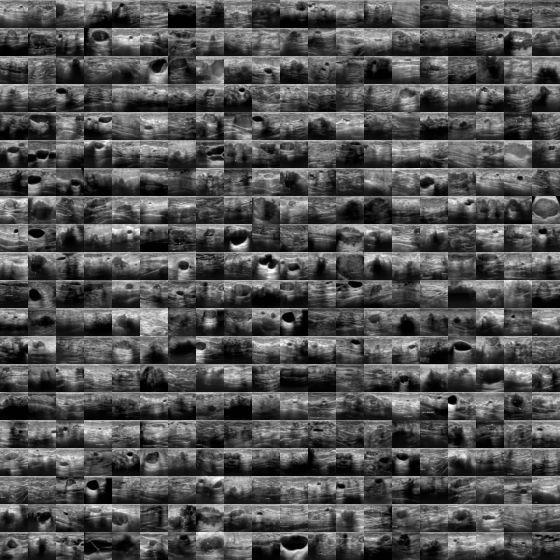

In [36]:
# montage

original_dataset.montage(length=20)

## Then, we define a simple model for illustration, object function and optimizer that we use to classify.

In [37]:
import torch
import torchvision.models as models
import torch.nn as nn

# resnet18 = models.resnet18(pretrained=True)

class ExtendedNetwork(nn.Module):
    def __init__(self, n_classes=2):
        # super(ExtendedNetwork, self).__init__()
        super().__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False)

        # Freeze all layers of the original ResNet18 model
        for param in self.resnet.parameters():
            param.requires_grad = False

        num_features = self.resnet.fc.in_features

        # self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 512)
        # Remove the final fc layer
        self.resnet.fc = nn.Identity()

        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.new_layers = nn.Sequential(
            # nn.BatchNorm1d(512),  # Batch norm matching the 256 output features
            # nn.ReLU(),
            # nn.Dropout(0.5),
            # nn.Linear(512, 128),
            # nn.ReLU(),
            # nn.BatchNorm1d(128),
            # nn.Dropout(0.3),
            # nn.Linear(128, n_classes)

            nn.BatchNorm1d(num_features),  # Match the batch norm to the output features of ResNet
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            nn.Linear(128, n_classes)
        )

    def forward(self, x):
        # x = self.features(x)
        x = self.resnet(x)
        x = self.new_layers(x)
        return x

In [38]:
network = ExtendedNetwork()
network.to(device=device)

print(network)

c:\Users\zayaa\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\zayaa\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ExtendedNetwork(
  (resnet): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

In [39]:
def accuracy(outputs, targets):
    pred = outputs.argmax(dim=1, keepdim=True)
    correct = pred.eq(targets.view_as(pred)).sum().item()
    return correct / len(targets)

## Next, we can start to train and evaluate!

c:\Users\zayaa\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Trial 1/5
TESTING ON HYPERPARAMETERS: Learning Rate: 0.001, Momentum: 0.99, Weight Decay: 0.0001



(Train) Epoch: 0 on cuda:   0%|          | 0/6 [00:00<?, ?it/s]

(Train) Epoch: 0 on cuda: 100%|██████████| 6/6 [00:00<00:00,  6.77it/s]


Train - Loss: 0.782682, Accuracy: 52.94% 



(Validation) Epoch: 0 on cuda: 100%|██████████| 1/1 [00:00<00:00, 15.14it/s]


Validation - Loss: 0.656556, Accuracy: 73.08% 



(Train) Epoch: 1 on cuda: 100%|██████████| 6/6 [00:00<00:00, 12.05it/s]


Train - Loss: 0.757474, Accuracy: 54.61% 



(Validation) Epoch: 1 on cuda: 100%|██████████| 1/1 [00:00<00:00, 15.05it/s]


Validation - Loss: 0.657149, Accuracy: 69.23% 



(Train) Epoch: 2 on cuda: 100%|██████████| 6/6 [00:00<00:00, 12.40it/s]


Train - Loss: 0.745870, Accuracy: 55.11% 



(Validation) Epoch: 2 on cuda: 100%|██████████| 1/1 [00:00<00:00, 14.60it/s]


Validation - Loss: 0.670692, Accuracy: 64.10% 



(Train) Epoch: 3 on cuda: 100%|██████████| 6/6 [00:00<00:00, 12.56it/s]


Train - Loss: 0.706484, Accuracy: 57.67% 



(Validation) Epoch: 3 on cuda: 100%|██████████| 1/1 [00:00<00:00, 14.60it/s]


Validation - Loss: 0.717835, Accuracy: 53.85% 



(Train) Epoch: 4 on cuda: 100%|██████████| 6/6 [00:00<00:00, 10.95it/s]


Train - Loss: 0.702904, Accuracy: 59.81% 



(Validation) Epoch: 4 on cuda: 100%|██████████| 1/1 [00:00<00:00,  7.06it/s]


Validation - Loss: 0.735782, Accuracy: 42.31% 



(Train) Epoch: 5 on cuda: 100%|██████████| 6/6 [00:00<00:00, 12.40it/s]


Train - Loss: 0.720618, Accuracy: 56.20% 



(Validation) Epoch: 5 on cuda: 100%|██████████| 1/1 [00:00<00:00, 14.81it/s]


Validation - Loss: 0.697641, Accuracy: 56.41% 



(Train) Epoch: 6 on cuda: 100%|██████████| 6/6 [00:00<00:00, 10.53it/s]


Train - Loss: 0.674334, Accuracy: 62.01% 



(Validation) Epoch: 6 on cuda: 100%|██████████| 1/1 [00:00<00:00, 14.71it/s]


Validation - Loss: 0.661252, Accuracy: 64.10% 



(Train) Epoch: 7 on cuda: 100%|██████████| 6/6 [00:00<00:00,  9.60it/s]


Train - Loss: 0.645320, Accuracy: 61.95% 



(Validation) Epoch: 7 on cuda: 100%|██████████| 1/1 [00:00<00:00, 11.24it/s]


Validation - Loss: 0.657155, Accuracy: 60.26% 



(Train) Epoch: 8 on cuda: 100%|██████████| 6/6 [00:00<00:00, 11.36it/s]


Train - Loss: 0.668925, Accuracy: 60.84% 



(Validation) Epoch: 8 on cuda: 100%|██████████| 1/1 [00:00<00:00, 14.81it/s]


Validation - Loss: 0.670182, Accuracy: 53.85% 



(Train) Epoch: 9 on cuda: 100%|██████████| 6/6 [00:00<00:00, 12.50it/s]


Train - Loss: 0.675163, Accuracy: 60.95% 



(Validation) Epoch: 9 on cuda: 100%|██████████| 1/1 [00:00<00:00, 14.81it/s]


Validation - Loss: 0.664038, Accuracy: 66.67% 



(Train) Epoch: 10 on cuda: 100%|██████████| 6/6 [00:00<00:00, 12.64it/s]


Train - Loss: 0.656447, Accuracy: 62.64% 



(Validation) Epoch: 10 on cuda: 100%|██████████| 1/1 [00:00<00:00, 13.24it/s]


Validation - Loss: 0.657004, Accuracy: 61.54% 



(Train) Epoch: 11 on cuda: 100%|██████████| 6/6 [00:00<00:00, 11.71it/s]


Train - Loss: 0.652685, Accuracy: 61.90% 



(Validation) Epoch: 11 on cuda: 100%|██████████| 1/1 [00:00<00:00, 11.05it/s]


Validation - Loss: 0.663559, Accuracy: 60.26% 



(Train) Epoch: 12 on cuda: 100%|██████████| 6/6 [00:00<00:00, 11.30it/s]


Train - Loss: 0.634308, Accuracy: 63.95% 



(Validation) Epoch: 12 on cuda: 100%|██████████| 1/1 [00:00<00:00, 14.17it/s]


Validation - Loss: 0.660798, Accuracy: 64.10% 



(Train) Epoch: 13 on cuda: 100%|██████████| 6/6 [00:00<00:00, 12.53it/s]


Train - Loss: 0.680579, Accuracy: 62.09% 



(Validation) Epoch: 13 on cuda: 100%|██████████| 1/1 [00:00<00:00, 14.49it/s]


Validation - Loss: 0.663354, Accuracy: 61.54% 



(Train) Epoch: 14 on cuda: 100%|██████████| 6/6 [00:00<00:00, 12.67it/s]


Train - Loss: 0.640883, Accuracy: 64.96% 



(Validation) Epoch: 14 on cuda: 100%|██████████| 1/1 [00:00<00:00,  9.05it/s]


Validation - Loss: 0.658872, Accuracy: 61.54% 



(Train) Epoch: 15 on cuda: 100%|██████████| 6/6 [00:00<00:00,  9.00it/s]


Train - Loss: 0.619509, Accuracy: 65.99% 



(Validation) Epoch: 15 on cuda: 100%|██████████| 1/1 [00:00<00:00,  9.30it/s]


Validation - Loss: 0.654049, Accuracy: 61.54% 



(Train) Epoch: 16 on cuda: 100%|██████████| 6/6 [00:00<00:00,  8.02it/s]


Train - Loss: 0.655889, Accuracy: 63.49% 



(Validation) Epoch: 16 on cuda: 100%|██████████| 1/1 [00:00<00:00, 11.68it/s]


Validation - Loss: 0.656344, Accuracy: 64.10% 



(Train) Epoch: 17 on cuda: 100%|██████████| 6/6 [00:00<00:00,  8.02it/s]


Train - Loss: 0.651208, Accuracy: 64.09% 



(Validation) Epoch: 17 on cuda: 100%|██████████| 1/1 [00:00<00:00,  7.14it/s]


Validation - Loss: 0.652273, Accuracy: 65.38% 



(Train) Epoch: 18 on cuda: 100%|██████████| 6/6 [00:00<00:00,  9.96it/s]


Train - Loss: 0.651985, Accuracy: 61.28% 



(Validation) Epoch: 18 on cuda: 100%|██████████| 1/1 [00:00<00:00, 14.24it/s]


Validation - Loss: 0.643615, Accuracy: 66.67% 



(Train) Epoch: 19 on cuda: 100%|██████████| 6/6 [00:00<00:00, 13.00it/s]


Train - Loss: 0.654757, Accuracy: 61.39% 



(Validation) Epoch: 19 on cuda: 100%|██████████| 1/1 [00:00<00:00, 15.74it/s]


Validation - Loss: 0.648047, Accuracy: 65.38% 

Trial 2/5
TESTING ON HYPERPARAMETERS: Learning Rate: 0.001, Momentum: 0.9, Weight Decay: 0.1



(Train) Epoch: 0 on cuda: 100%|██████████| 6/6 [00:00<00:00, 12.24it/s]


Train - Loss: 0.659023, Accuracy: 60.84% 



(Validation) Epoch: 0 on cuda: 100%|██████████| 1/1 [00:00<00:00, 15.15it/s]


Validation - Loss: 0.646444, Accuracy: 62.82% 



(Train) Epoch: 1 on cuda: 100%|██████████| 6/6 [00:00<00:00, 13.07it/s]


Train - Loss: 0.634080, Accuracy: 64.07% 



(Validation) Epoch: 1 on cuda: 100%|██████████| 1/1 [00:00<00:00, 10.36it/s]


Validation - Loss: 0.645273, Accuracy: 65.38% 



(Train) Epoch: 2 on cuda: 100%|██████████| 6/6 [00:00<00:00, 13.11it/s]


Train - Loss: 0.640406, Accuracy: 63.04% 



(Validation) Epoch: 2 on cuda: 100%|██████████| 1/1 [00:00<00:00, 15.15it/s]


Validation - Loss: 0.640832, Accuracy: 66.67% 



(Train) Epoch: 3 on cuda: 100%|██████████| 6/6 [00:00<00:00, 13.20it/s]


Train - Loss: 0.621885, Accuracy: 66.42% 



(Validation) Epoch: 3 on cuda: 100%|██████████| 1/1 [00:00<00:00, 15.02it/s]


Validation - Loss: 0.637344, Accuracy: 65.38% 



(Train) Epoch: 4 on cuda: 100%|██████████| 6/6 [00:00<00:00, 13.23it/s]


Train - Loss: 0.630211, Accuracy: 62.90% 



(Validation) Epoch: 4 on cuda: 100%|██████████| 1/1 [00:00<00:00, 15.74it/s]


Validation - Loss: 0.631912, Accuracy: 66.67% 



(Train) Epoch: 5 on cuda: 100%|██████████| 6/6 [00:00<00:00, 12.68it/s]


Train - Loss: 0.624312, Accuracy: 64.51% 



(Validation) Epoch: 5 on cuda: 100%|██████████| 1/1 [00:00<00:00, 13.89it/s]


Validation - Loss: 0.626202, Accuracy: 69.23% 



(Train) Epoch: 6 on cuda: 100%|██████████| 6/6 [00:00<00:00, 12.44it/s]


Train - Loss: 0.632090, Accuracy: 65.12% 



(Validation) Epoch: 6 on cuda: 100%|██████████| 1/1 [00:00<00:00, 15.50it/s]


Validation - Loss: 0.618932, Accuracy: 74.36% 



(Train) Epoch: 7 on cuda: 100%|██████████| 6/6 [00:00<00:00, 13.35it/s]


Train - Loss: 0.605310, Accuracy: 66.64% 



(Validation) Epoch: 7 on cuda: 100%|██████████| 1/1 [00:00<00:00, 15.35it/s]


Validation - Loss: 0.619745, Accuracy: 73.08% 



(Train) Epoch: 8 on cuda: 100%|██████████| 6/6 [00:00<00:00, 13.29it/s]


Train - Loss: 0.579172, Accuracy: 72.26% 



(Validation) Epoch: 8 on cuda: 100%|██████████| 1/1 [00:00<00:00, 13.51it/s]


Validation - Loss: 0.614037, Accuracy: 75.64% 



(Train) Epoch: 9 on cuda: 100%|██████████| 6/6 [00:00<00:00, 12.92it/s]


Train - Loss: 0.607626, Accuracy: 66.07% 



(Validation) Epoch: 9 on cuda: 100%|██████████| 1/1 [00:00<00:00, 15.74it/s]


Validation - Loss: 0.606972, Accuracy: 76.92% 



(Train) Epoch: 10 on cuda: 100%|██████████| 6/6 [00:00<00:00, 13.21it/s]


Train - Loss: 0.607738, Accuracy: 66.59% 



(Validation) Epoch: 10 on cuda: 100%|██████████| 1/1 [00:00<00:00, 15.75it/s]


Validation - Loss: 0.608567, Accuracy: 78.21% 



(Train) Epoch: 11 on cuda: 100%|██████████| 6/6 [00:00<00:00, 13.04it/s]


Train - Loss: 0.603589, Accuracy: 66.70% 



(Validation) Epoch: 11 on cuda: 100%|██████████| 1/1 [00:00<00:00, 15.69it/s]


Validation - Loss: 0.601994, Accuracy: 83.33% 



(Train) Epoch: 12 on cuda: 100%|██████████| 6/6 [00:00<00:00, 12.42it/s]


Train - Loss: 0.590115, Accuracy: 70.49% 



(Validation) Epoch: 12 on cuda: 100%|██████████| 1/1 [00:00<00:00, 12.61it/s]


Validation - Loss: 0.601484, Accuracy: 80.77% 



(Train) Epoch: 13 on cuda: 100%|██████████| 6/6 [00:00<00:00, 12.70it/s]


Train - Loss: 0.562926, Accuracy: 72.15% 



(Validation) Epoch: 13 on cuda: 100%|██████████| 1/1 [00:00<00:00, 15.26it/s]


Validation - Loss: 0.594655, Accuracy: 80.77% 



(Train) Epoch: 14 on cuda: 100%|██████████| 6/6 [00:00<00:00, 13.08it/s]


Train - Loss: 0.575400, Accuracy: 70.67% 



(Validation) Epoch: 14 on cuda: 100%|██████████| 1/1 [00:00<00:00, 13.42it/s]


Validation - Loss: 0.591390, Accuracy: 80.77% 



(Train) Epoch: 15 on cuda: 100%|██████████| 6/6 [00:00<00:00, 12.33it/s]


Train - Loss: 0.573021, Accuracy: 73.35% 



(Validation) Epoch: 15 on cuda: 100%|██████████| 1/1 [00:00<00:00, 16.13it/s]


Validation - Loss: 0.588687, Accuracy: 79.49% 



(Train) Epoch: 16 on cuda: 100%|██████████| 6/6 [00:00<00:00, 13.11it/s]


Train - Loss: 0.579754, Accuracy: 72.24% 



(Validation) Epoch: 16 on cuda: 100%|██████████| 1/1 [00:00<00:00, 15.74it/s]


Validation - Loss: 0.586869, Accuracy: 79.49% 



(Train) Epoch: 17 on cuda: 100%|██████████| 6/6 [00:00<00:00, 12.90it/s]


Train - Loss: 0.595983, Accuracy: 68.22% 



(Validation) Epoch: 17 on cuda: 100%|██████████| 1/1 [00:00<00:00, 13.33it/s]


Validation - Loss: 0.588087, Accuracy: 78.21% 



(Train) Epoch: 18 on cuda: 100%|██████████| 6/6 [00:00<00:00, 12.43it/s]


Train - Loss: 0.583032, Accuracy: 68.98% 



(Validation) Epoch: 18 on cuda: 100%|██████████| 1/1 [00:00<00:00, 15.02it/s]


Validation - Loss: 0.580768, Accuracy: 78.21% 



(Train) Epoch: 19 on cuda: 100%|██████████| 6/6 [00:00<00:00, 13.30it/s]


Train - Loss: 0.557205, Accuracy: 74.49% 



(Validation) Epoch: 19 on cuda: 100%|██████████| 1/1 [00:00<00:00, 15.63it/s]


Validation - Loss: 0.576140, Accuracy: 76.92% 

Trial 3/5
TESTING ON HYPERPARAMETERS: Learning Rate: 0.001, Momentum: 0.99, Weight Decay: 0.01



(Train) Epoch: 0 on cuda: 100%|██████████| 6/6 [00:00<00:00, 13.13it/s]


Train - Loss: 0.584580, Accuracy: 68.87% 



(Validation) Epoch: 0 on cuda: 100%|██████████| 1/1 [00:00<00:00, 15.38it/s]


Validation - Loss: 0.573771, Accuracy: 78.21% 



(Train) Epoch: 1 on cuda: 100%|██████████| 6/6 [00:00<00:00, 12.85it/s]


Train - Loss: 0.572067, Accuracy: 70.96% 



(Validation) Epoch: 1 on cuda: 100%|██████████| 1/1 [00:00<00:00,  7.78it/s]


Validation - Loss: 0.573011, Accuracy: 78.21% 



(Train) Epoch: 2 on cuda: 100%|██████████| 6/6 [00:00<00:00, 12.26it/s]


Train - Loss: 0.539898, Accuracy: 78.74% 



(Validation) Epoch: 2 on cuda: 100%|██████████| 1/1 [00:00<00:00, 15.74it/s]


Validation - Loss: 0.571387, Accuracy: 79.49% 



(Train) Epoch: 3 on cuda: 100%|██████████| 6/6 [00:00<00:00, 12.98it/s]


Train - Loss: 0.550835, Accuracy: 74.29% 



(Validation) Epoch: 3 on cuda: 100%|██████████| 1/1 [00:00<00:00, 15.62it/s]


Validation - Loss: 0.565228, Accuracy: 79.49% 



(Train) Epoch: 4 on cuda: 100%|██████████| 6/6 [00:00<00:00, 12.76it/s]


Train - Loss: 0.552261, Accuracy: 71.95% 



(Validation) Epoch: 4 on cuda: 100%|██████████| 1/1 [00:00<00:00, 15.99it/s]


Validation - Loss: 0.552115, Accuracy: 80.77% 



(Train) Epoch: 5 on cuda: 100%|██████████| 6/6 [00:00<00:00, 12.13it/s]


Train - Loss: 0.549549, Accuracy: 73.29% 



(Validation) Epoch: 5 on cuda: 100%|██████████| 1/1 [00:00<00:00, 14.70it/s]


Validation - Loss: 0.547595, Accuracy: 80.77% 



(Train) Epoch: 6 on cuda: 100%|██████████| 6/6 [00:00<00:00,  8.74it/s]


Train - Loss: 0.514206, Accuracy: 77.77% 



(Validation) Epoch: 6 on cuda: 100%|██████████| 1/1 [00:00<00:00,  6.75it/s]


Validation - Loss: 0.540398, Accuracy: 80.77% 



(Train) Epoch: 7 on cuda: 100%|██████████| 6/6 [00:00<00:00, 11.37it/s]


Train - Loss: 0.523635, Accuracy: 78.88% 



(Validation) Epoch: 7 on cuda: 100%|██████████| 1/1 [00:00<00:00, 10.15it/s]


Validation - Loss: 0.531056, Accuracy: 82.05% 



(Train) Epoch: 8 on cuda: 100%|██████████| 6/6 [00:00<00:00,  9.45it/s]


Train - Loss: 0.510831, Accuracy: 76.32% 



(Validation) Epoch: 8 on cuda: 100%|██████████| 1/1 [00:00<00:00, 15.15it/s]


Validation - Loss: 0.516085, Accuracy: 82.05% 



(Train) Epoch: 9 on cuda: 100%|██████████| 6/6 [00:00<00:00, 10.95it/s]


Train - Loss: 0.501486, Accuracy: 78.12% 



(Validation) Epoch: 9 on cuda: 100%|██████████| 1/1 [00:00<00:00, 14.81it/s]


Validation - Loss: 0.503996, Accuracy: 83.33% 



(Train) Epoch: 10 on cuda: 100%|██████████| 6/6 [00:00<00:00, 12.52it/s]


Train - Loss: 0.496012, Accuracy: 77.01% 



(Validation) Epoch: 10 on cuda: 100%|██████████| 1/1 [00:00<00:00, 15.74it/s]


Validation - Loss: 0.495480, Accuracy: 83.33% 



(Train) Epoch: 11 on cuda: 100%|██████████| 6/6 [00:00<00:00,  9.71it/s]


Train - Loss: 0.478605, Accuracy: 80.52% 



(Validation) Epoch: 11 on cuda: 100%|██████████| 1/1 [00:00<00:00, 15.26it/s]


Validation - Loss: 0.486291, Accuracy: 83.33% 



(Train) Epoch: 12 on cuda: 100%|██████████| 6/6 [00:00<00:00, 12.42it/s]


Train - Loss: 0.490165, Accuracy: 78.57% 



(Validation) Epoch: 12 on cuda: 100%|██████████| 1/1 [00:00<00:00, 13.86it/s]


Validation - Loss: 0.476120, Accuracy: 84.62% 



(Train) Epoch: 13 on cuda: 100%|██████████| 6/6 [00:00<00:00, 11.92it/s]


Train - Loss: 0.455138, Accuracy: 80.60% 



(Validation) Epoch: 13 on cuda: 100%|██████████| 1/1 [00:00<00:00, 10.60it/s]


Validation - Loss: 0.467231, Accuracy: 84.62% 



(Train) Epoch: 14 on cuda: 100%|██████████| 6/6 [00:00<00:00,  9.86it/s]


Train - Loss: 0.463580, Accuracy: 79.68% 



(Validation) Epoch: 14 on cuda: 100%|██████████| 1/1 [00:00<00:00, 13.79it/s]


Validation - Loss: 0.454101, Accuracy: 84.62% 



(Train) Epoch: 15 on cuda: 100%|██████████| 6/6 [00:00<00:00, 12.48it/s]


Train - Loss: 0.430838, Accuracy: 82.46% 



(Validation) Epoch: 15 on cuda: 100%|██████████| 1/1 [00:00<00:00, 14.80it/s]


Validation - Loss: 0.448154, Accuracy: 84.62% 



(Train) Epoch: 16 on cuda: 100%|██████████| 6/6 [00:00<00:00, 11.14it/s]


Train - Loss: 0.431502, Accuracy: 81.93% 



(Validation) Epoch: 16 on cuda: 100%|██████████| 1/1 [00:00<00:00, 14.70it/s]


Validation - Loss: 0.440752, Accuracy: 84.62% 



(Train) Epoch: 17 on cuda: 100%|██████████| 6/6 [00:00<00:00, 12.31it/s]


Train - Loss: 0.418772, Accuracy: 80.69% 



(Validation) Epoch: 17 on cuda: 100%|██████████| 1/1 [00:00<00:00, 15.02it/s]


Validation - Loss: 0.434253, Accuracy: 84.62% 



(Train) Epoch: 18 on cuda: 100%|██████████| 6/6 [00:00<00:00, 12.39it/s]


Train - Loss: 0.416208, Accuracy: 81.66% 



(Validation) Epoch: 18 on cuda: 100%|██████████| 1/1 [00:00<00:00, 11.83it/s]


Validation - Loss: 0.428590, Accuracy: 84.62% 



(Train) Epoch: 19 on cuda: 100%|██████████| 6/6 [00:00<00:00, 11.55it/s]


Train - Loss: 0.415055, Accuracy: 81.12% 



(Validation) Epoch: 19 on cuda: 100%|██████████| 1/1 [00:00<00:00, 14.70it/s]


Validation - Loss: 0.426562, Accuracy: 84.62% 

Trial 4/5
TESTING ON HYPERPARAMETERS: Learning Rate: 0.0005, Momentum: 0.9, Weight Decay: 0.1



(Train) Epoch: 0 on cuda: 100%|██████████| 6/6 [00:00<00:00, 12.53it/s]


Train - Loss: 0.388311, Accuracy: 83.99% 



(Validation) Epoch: 0 on cuda: 100%|██████████| 1/1 [00:00<00:00, 13.98it/s]


Validation - Loss: 0.427490, Accuracy: 83.33% 



(Train) Epoch: 1 on cuda: 100%|██████████| 6/6 [00:00<00:00, 12.56it/s]


Train - Loss: 0.397712, Accuracy: 82.01% 



(Validation) Epoch: 1 on cuda: 100%|██████████| 1/1 [00:00<00:00, 15.26it/s]


Validation - Loss: 0.425889, Accuracy: 84.62% 



(Train) Epoch: 2 on cuda: 100%|██████████| 6/6 [00:00<00:00, 12.75it/s]


Train - Loss: 0.400378, Accuracy: 82.66% 



(Validation) Epoch: 2 on cuda: 100%|██████████| 1/1 [00:00<00:00, 14.48it/s]


Validation - Loss: 0.427184, Accuracy: 83.33% 



(Train) Epoch: 3 on cuda: 100%|██████████| 6/6 [00:00<00:00, 12.65it/s]


Train - Loss: 0.385756, Accuracy: 83.24% 



(Validation) Epoch: 3 on cuda: 100%|██████████| 1/1 [00:00<00:00, 13.79it/s]


Validation - Loss: 0.424843, Accuracy: 85.90% 



(Train) Epoch: 4 on cuda: 100%|██████████| 6/6 [00:00<00:00, 12.10it/s]


Train - Loss: 0.427480, Accuracy: 80.51% 



(Validation) Epoch: 4 on cuda: 100%|██████████| 1/1 [00:00<00:00, 14.70it/s]


Validation - Loss: 0.429881, Accuracy: 84.62% 



(Train) Epoch: 5 on cuda: 100%|██████████| 6/6 [00:00<00:00, 12.73it/s]


Train - Loss: 0.401802, Accuracy: 82.27% 



(Validation) Epoch: 5 on cuda: 100%|██████████| 1/1 [00:00<00:00, 14.59it/s]


Validation - Loss: 0.428259, Accuracy: 85.90% 



(Train) Epoch: 6 on cuda: 100%|██████████| 6/6 [00:00<00:00, 12.54it/s]


Train - Loss: 0.381359, Accuracy: 83.27% 



(Validation) Epoch: 6 on cuda: 100%|██████████| 1/1 [00:00<00:00, 14.49it/s]


Validation - Loss: 0.425801, Accuracy: 85.90% 



(Train) Epoch: 7 on cuda: 100%|██████████| 6/6 [00:00<00:00, 11.44it/s]


Train - Loss: 0.367454, Accuracy: 86.05% 



(Validation) Epoch: 7 on cuda: 100%|██████████| 1/1 [00:00<00:00, 14.71it/s]


Validation - Loss: 0.431435, Accuracy: 83.33% 



(Train) Epoch: 8 on cuda: 100%|██████████| 6/6 [00:00<00:00, 12.55it/s]


Train - Loss: 0.385704, Accuracy: 84.41% 



(Validation) Epoch: 8 on cuda: 100%|██████████| 1/1 [00:00<00:00, 15.03it/s]


Validation - Loss: 0.429825, Accuracy: 85.90% 



(Train) Epoch: 9 on cuda: 100%|██████████| 6/6 [00:00<00:00, 12.59it/s]


Train - Loss: 0.382212, Accuracy: 86.41% 



(Validation) Epoch: 9 on cuda: 100%|██████████| 1/1 [00:00<00:00,  8.97it/s]


Validation - Loss: 0.426697, Accuracy: 85.90% 



(Train) Epoch: 10 on cuda: 100%|██████████| 6/6 [00:00<00:00, 11.10it/s]


Train - Loss: 0.390854, Accuracy: 84.10% 



(Validation) Epoch: 10 on cuda: 100%|██████████| 1/1 [00:00<00:00, 15.03it/s]


Validation - Loss: 0.427631, Accuracy: 85.90% 



(Train) Epoch: 11 on cuda: 100%|██████████| 6/6 [00:00<00:00, 12.09it/s]


Train - Loss: 0.399939, Accuracy: 82.71% 



(Validation) Epoch: 11 on cuda: 100%|██████████| 1/1 [00:00<00:00, 14.70it/s]


Validation - Loss: 0.427833, Accuracy: 85.90% 



(Train) Epoch: 12 on cuda: 100%|██████████| 6/6 [00:00<00:00, 12.06it/s]


Train - Loss: 0.390183, Accuracy: 82.99% 



(Validation) Epoch: 12 on cuda: 100%|██████████| 1/1 [00:00<00:00, 14.28it/s]


Validation - Loss: 0.431373, Accuracy: 84.62% 



(Train) Epoch: 13 on cuda: 100%|██████████| 6/6 [00:00<00:00, 11.57it/s]


Train - Loss: 0.394819, Accuracy: 83.83% 



(Validation) Epoch: 13 on cuda: 100%|██████████| 1/1 [00:00<00:00, 13.79it/s]


Validation - Loss: 0.431492, Accuracy: 85.90% 



(Train) Epoch: 14 on cuda: 100%|██████████| 6/6 [00:00<00:00, 12.57it/s]


Train - Loss: 0.393517, Accuracy: 84.02% 



(Validation) Epoch: 14 on cuda: 100%|██████████| 1/1 [00:00<00:00, 13.79it/s]


Validation - Loss: 0.431461, Accuracy: 85.90% 



(Train) Epoch: 15 on cuda: 100%|██████████| 6/6 [00:00<00:00, 11.08it/s]


Train - Loss: 0.407239, Accuracy: 80.99% 



(Validation) Epoch: 15 on cuda: 100%|██████████| 1/1 [00:00<00:00, 14.38it/s]


Validation - Loss: 0.431102, Accuracy: 85.90% 



(Train) Epoch: 16 on cuda: 100%|██████████| 6/6 [00:00<00:00, 12.34it/s]


Train - Loss: 0.402449, Accuracy: 84.49% 



(Validation) Epoch: 16 on cuda: 100%|██████████| 1/1 [00:00<00:00, 14.80it/s]


Validation - Loss: 0.428126, Accuracy: 85.90% 



(Train) Epoch: 17 on cuda: 100%|██████████| 6/6 [00:00<00:00, 12.21it/s]


Train - Loss: 0.364892, Accuracy: 86.91% 



(Validation) Epoch: 17 on cuda: 100%|██████████| 1/1 [00:00<00:00, 15.50it/s]


Validation - Loss: 0.430808, Accuracy: 84.62% 



(Train) Epoch: 18 on cuda: 100%|██████████| 6/6 [00:00<00:00, 11.45it/s]


Train - Loss: 0.396779, Accuracy: 84.55% 



(Validation) Epoch: 18 on cuda: 100%|██████████| 1/1 [00:00<00:00, 14.81it/s]


Validation - Loss: 0.431729, Accuracy: 84.62% 



(Train) Epoch: 19 on cuda: 100%|██████████| 6/6 [00:00<00:00, 12.48it/s]


Train - Loss: 0.392853, Accuracy: 84.77% 



(Validation) Epoch: 19 on cuda: 100%|██████████| 1/1 [00:00<00:00, 13.60it/s]


Validation - Loss: 0.432938, Accuracy: 83.33% 

Trial 5/5
TESTING ON HYPERPARAMETERS: Learning Rate: 0.001, Momentum: 0.99, Weight Decay: 0.001



(Train) Epoch: 0 on cuda: 100%|██████████| 6/6 [00:00<00:00, 12.73it/s]


Train - Loss: 0.411894, Accuracy: 80.99% 



(Validation) Epoch: 0 on cuda: 100%|██████████| 1/1 [00:00<00:00, 14.81it/s]


Validation - Loss: 0.434317, Accuracy: 83.33% 



(Train) Epoch: 1 on cuda: 100%|██████████| 6/6 [00:00<00:00, 11.15it/s]


Train - Loss: 0.393377, Accuracy: 83.60% 



(Validation) Epoch: 1 on cuda: 100%|██████████| 1/1 [00:00<00:00, 14.93it/s]


Validation - Loss: 0.433156, Accuracy: 83.33% 



(Train) Epoch: 2 on cuda: 100%|██████████| 6/6 [00:00<00:00, 12.38it/s]


Train - Loss: 0.409259, Accuracy: 82.88% 



(Validation) Epoch: 2 on cuda: 100%|██████████| 1/1 [00:00<00:00, 13.60it/s]


Validation - Loss: 0.428930, Accuracy: 84.62% 



(Train) Epoch: 3 on cuda: 100%|██████████| 6/6 [00:00<00:00, 11.43it/s]


Train - Loss: 0.379944, Accuracy: 84.41% 



(Validation) Epoch: 3 on cuda: 100%|██████████| 1/1 [00:00<00:00, 15.03it/s]


Validation - Loss: 0.424581, Accuracy: 83.33% 



(Train) Epoch: 4 on cuda: 100%|██████████| 6/6 [00:00<00:00, 12.42it/s]


Train - Loss: 0.383110, Accuracy: 83.93% 



(Validation) Epoch: 4 on cuda: 100%|██████████| 1/1 [00:00<00:00, 15.15it/s]


Validation - Loss: 0.425511, Accuracy: 84.62% 



(Train) Epoch: 5 on cuda: 100%|██████████| 6/6 [00:00<00:00, 12.51it/s]


Train - Loss: 0.404538, Accuracy: 81.35% 



(Validation) Epoch: 5 on cuda: 100%|██████████| 1/1 [00:00<00:00, 14.59it/s]


Validation - Loss: 0.424287, Accuracy: 85.90% 



(Train) Epoch: 6 on cuda: 100%|██████████| 6/6 [00:00<00:00, 11.97it/s]


Train - Loss: 0.363465, Accuracy: 85.88% 



(Validation) Epoch: 6 on cuda: 100%|██████████| 1/1 [00:00<00:00, 13.42it/s]


Validation - Loss: 0.422897, Accuracy: 85.90% 



(Train) Epoch: 7 on cuda: 100%|██████████| 6/6 [00:00<00:00, 11.24it/s]


Train - Loss: 0.371842, Accuracy: 84.99% 



(Validation) Epoch: 7 on cuda: 100%|██████████| 1/1 [00:00<00:00, 13.07it/s]


Validation - Loss: 0.428527, Accuracy: 84.62% 



(Train) Epoch: 8 on cuda: 100%|██████████| 6/6 [00:00<00:00, 12.51it/s]


Train - Loss: 0.373168, Accuracy: 85.30% 



(Validation) Epoch: 8 on cuda: 100%|██████████| 1/1 [00:00<00:00, 15.36it/s]


Validation - Loss: 0.425914, Accuracy: 85.90% 



(Train) Epoch: 9 on cuda: 100%|██████████| 6/6 [00:00<00:00, 12.47it/s]


Train - Loss: 0.373989, Accuracy: 82.88% 



(Validation) Epoch: 9 on cuda: 100%|██████████| 1/1 [00:00<00:00, 14.60it/s]


Validation - Loss: 0.425427, Accuracy: 85.90% 



(Train) Epoch: 10 on cuda: 100%|██████████| 6/6 [00:00<00:00, 11.36it/s]


Train - Loss: 0.377820, Accuracy: 85.19% 



(Validation) Epoch: 10 on cuda: 100%|██████████| 1/1 [00:00<00:00, 15.11it/s]


Validation - Loss: 0.428585, Accuracy: 85.90% 



(Train) Epoch: 11 on cuda: 100%|██████████| 6/6 [00:00<00:00, 12.19it/s]


Train - Loss: 0.349454, Accuracy: 86.38% 



(Validation) Epoch: 11 on cuda: 100%|██████████| 1/1 [00:00<00:00, 15.28it/s]


Validation - Loss: 0.427536, Accuracy: 85.90% 



(Train) Epoch: 12 on cuda: 100%|██████████| 6/6 [00:00<00:00, 11.52it/s]


Train - Loss: 0.334108, Accuracy: 86.19% 



(Validation) Epoch: 12 on cuda: 100%|██████████| 1/1 [00:00<00:00, 13.41it/s]


Validation - Loss: 0.425335, Accuracy: 85.90% 



(Train) Epoch: 13 on cuda: 100%|██████████| 6/6 [00:00<00:00, 12.36it/s]


Train - Loss: 0.335340, Accuracy: 86.55% 



(Validation) Epoch: 13 on cuda: 100%|██████████| 1/1 [00:00<00:00, 14.49it/s]


Validation - Loss: 0.424857, Accuracy: 85.90% 



(Train) Epoch: 14 on cuda: 100%|██████████| 6/6 [00:00<00:00, 12.64it/s]


Train - Loss: 0.350697, Accuracy: 85.96% 



(Validation) Epoch: 14 on cuda: 100%|██████████| 1/1 [00:00<00:00, 15.02it/s]


Validation - Loss: 0.423419, Accuracy: 85.90% 



(Train) Epoch: 15 on cuda: 100%|██████████| 6/6 [00:00<00:00, 11.46it/s]


Train - Loss: 0.352674, Accuracy: 84.05% 



(Validation) Epoch: 15 on cuda: 100%|██████████| 1/1 [00:00<00:00, 15.14it/s]


Validation - Loss: 0.418433, Accuracy: 84.62% 



(Train) Epoch: 16 on cuda: 100%|██████████| 6/6 [00:00<00:00, 12.58it/s]


Train - Loss: 0.345172, Accuracy: 85.21% 



(Validation) Epoch: 16 on cuda: 100%|██████████| 1/1 [00:00<00:00, 14.93it/s]


Validation - Loss: 0.423306, Accuracy: 84.62% 



(Train) Epoch: 17 on cuda: 100%|██████████| 6/6 [00:00<00:00, 12.62it/s]


Train - Loss: 0.382808, Accuracy: 83.21% 



(Validation) Epoch: 17 on cuda: 100%|██████████| 1/1 [00:00<00:00, 13.24it/s]


Validation - Loss: 0.421647, Accuracy: 84.62% 



(Train) Epoch: 18 on cuda: 100%|██████████| 6/6 [00:00<00:00, 11.55it/s]


Train - Loss: 0.330624, Accuracy: 88.02% 



(Validation) Epoch: 18 on cuda: 100%|██████████| 1/1 [00:00<00:00, 15.03it/s]


Validation - Loss: 0.420978, Accuracy: 84.62% 



(Train) Epoch: 19 on cuda: 100%|██████████| 6/6 [00:00<00:00, 12.76it/s]


Train - Loss: 0.364562, Accuracy: 84.52% 



(Validation) Epoch: 19 on cuda: 100%|██████████| 1/1 [00:00<00:00, 14.93it/s]

Validation - Loss: 0.421693, Accuracy: 84.62% 


Best Hyperparameters:
{'learning_rate': 0.001, 'momentum': 0.99, 'weight_decay': 0.001}
Best Training Accuracy: 88.02%
Best Validation Accuracy: 85.90%


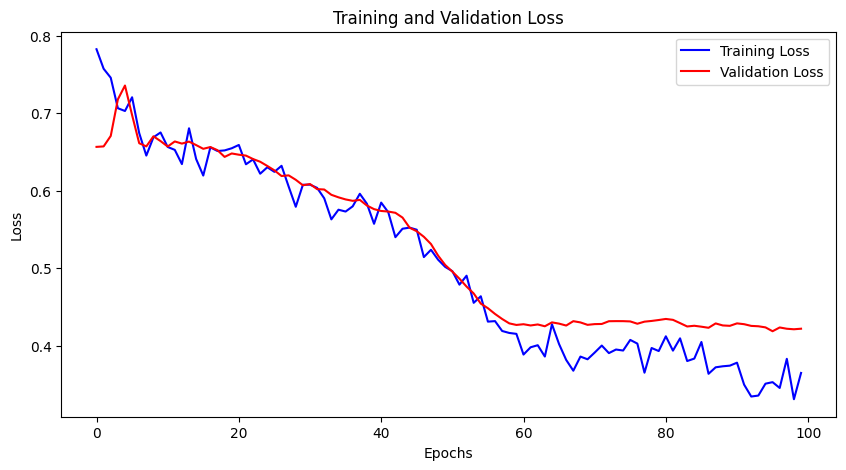

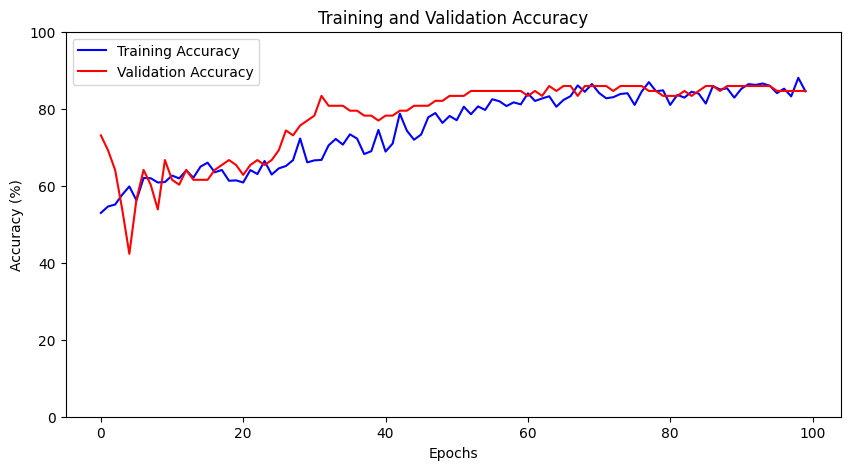

In [40]:
import matplotlib.pyplot as plt

# train

#loss_function = nn.BCEWithLogitsLoss() # Each sample belongs to one of two classes (0 or 1) so we can use this loss function.
loss_function = nn.CrossEntropyLoss()

best_train_accuracy = 0
best_val_accuracy = 0
best_hyperparameters = {}

# Lists to store average accuracy
avg_train_accuracies = []
avg_val_accuracies = []

# Lists to store average losses
avg_train_losses = []
avg_val_losses = []


for trial in range(RANDOM_SEARCH_TRIALS):
    print(f"Trial {trial + 1}/{RANDOM_SEARCH_TRIALS}")

    learning_rate = np.random.choice(LEARNING_RATES)
    momentum = np.random.choice(MOMENTUM_VALUES)
    weight_decay = np.random.choice(WEIGHT_DECAYS)

    print(f"TESTING ON HYPERPARAMETERS: Learning Rate: {learning_rate}, Momentum: {momentum}, Weight Decay: {weight_decay}\n")

    optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.1, verbose=True)
    # scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    trial_train_accuracies = []
    trial_val_accuracies = []

    for epoch in range(NUM_EPOCHS):
        # running loss and acurracy
        running_loss = 0.0
        running_accuracy = 0.0

        network.train()
        for inputs, targets in tqdm(train_loader, desc="(Train) Epoch: " + str(epoch) + " on " + str(device)):
            # forward + backward + optimize
            inputs, targets = inputs.to(device), targets.to(device)
            

            optimizer.zero_grad()
            outputs = network(inputs)

            targets = targets.squeeze().long()
            
            # Call Loss function
            cross_entropy_loss = loss_function(outputs, targets)

            # Call Backward function
            cross_entropy_loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(network.parameters(), max_norm=1.0)

            optimizer.step()

            running_loss += cross_entropy_loss.item() #/ len(inputs)
            running_accuracy += accuracy(outputs, targets)

        # Train Accuracy calculation
        epoch_accuracy = running_accuracy / len(train_loader)
        avg_train_accuracies.append(epoch_accuracy)
        
        # Train Loss calculation
        epoch_loss = running_loss / len(train_loader)
        avg_train_losses.append(epoch_loss)

        print("Train - Loss: {:.6f}, Accuracy: {:.2f}%".format(epoch_loss, running_accuracy / len(train_loader) * 100), "\n")

        # Validation
        network.eval()
        val_running_loss = 0.0
        val_running_accuracy = 0.0
        with torch.no_grad():
            for val_inputs, val_targets in tqdm(validation_loader, desc="(Validation) Epoch: " + str(epoch) + " on " + str(device)):
                val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)

                val_outputs = network(val_inputs)

                # val_outputs = F.softmax(val_outputs, dim=1)

                val_targets = val_targets.squeeze().long()

                val_running_loss += loss_function(val_outputs, val_targets).item()
                val_running_accuracy += accuracy(val_outputs, val_targets)

        # Validation Accuracy calculation
        val_epoch_accuracy = val_running_accuracy / len(validation_loader)
        avg_val_accuracies.append(val_epoch_accuracy)

        # Validation Loss calculation
        val_epoch_loss = val_running_loss / len(validation_loader)
        avg_val_losses.append(val_epoch_loss)

        scheduler.step(val_epoch_loss)

        print("Validation - Loss: {:.6f}, Accuracy: {:.2f}%".format(val_epoch_loss, val_running_accuracy / len(validation_loader) * 100), "\n")

        # Check if this trial has the best accuracy
        if running_accuracy > best_train_accuracy:
            best_train_accuracy = running_accuracy
            best_hyperparameters = {
                "learning_rate": learning_rate,
                "momentum": momentum,
                "weight_decay": weight_decay
            }
        if val_running_accuracy > best_val_accuracy:
            best_val_accuracy = val_running_accuracy

# Print the best hyperparameters and accuracy
print("\nBest Hyperparameters:")
print(best_hyperparameters)
print("Best Training Accuracy: {:.2f}%".format(best_train_accuracy / len(train_loader) * 100))
print("Best Validation Accuracy: {:.2f}%".format(best_val_accuracy / len(validation_loader) * 100))

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Loss")
plt.plot(avg_train_losses, label="Training Loss", color="blue")
plt.plot(avg_val_losses, label="Validation Loss", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plotting the training and validation accuracies
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Accuracy")
plt.plot([100 * acc for acc in avg_train_accuracies], label="Training Accuracy", color="blue")
plt.plot([100 * acc for acc in avg_val_accuracies], label="Validation Accuracy", color="red")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.ylim(0, 100)  # Set y-axis to show percentages from 0 to 100
plt.show()

In [41]:
# evaluation

def test(split):
    network.eval()
    y_true = torch.tensor([], device=device)
    y_score = torch.tensor([], device=device)

    data_loader = train_loader_at_eval if split == 'train' else test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = network(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.cpu().numpy()
        y_score = y_score.cpu().detach().numpy()

        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)

        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))


print('==> Evaluating ...')
test('train')
test('test')

==> Evaluating ...
train  auc: 0.991  acc:0.947
test  auc: 0.822  acc:0.776


In [ ]:
import torch
from PIL import Image
from torchvision import transforms

# Assume 'model' is your trained model
network.eval()

# Assuming you have a DataLoader for your test data
# For a specific image, you might load it directly as shown below
image, label = pil_dataset[20]

# Transform the image according to your model's expected input
# This should match your training transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Example size, adjust as necessary
    transforms.ToTensor(),
    # Include normalization if used during training
])

# Apply transformation
image = transform(image).unsqueeze(0)  # Add batch dimension

# Move image to the same device as your model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image = image.to(device)
model = network.to(device)

with torch.no_grad():
    output = model(image)

# Assuming the output is logits; apply softmax for probabilities
probabilities = torch.softmax(output, dim=1).cpu().numpy().flatten()

# Assuming class 0 is 'benign' and class 1 is 'malignant'
classes = ['benign', 'malignant']
predicted_class = classes[probabilities.argmax()]
confidence = probabilities.max()

print(f"Predicted class: {predicted_class} with confidence {confidence:.2f}")


image_np = image.squeeze().cpu().numpy()

# If the image is grayscale (C, H, W) where C = 1, we convert it to (H, W) for matplotlib
if image_np.shape[0] == 1:  # Grayscale image, single channel
    image_np = image_np.squeeze(0)  # Now shape is (H, W)
elif image_np.shape[0] == 3:  # If it's a 3-channel image
    # Convert from (C, H, W) to (H, W, C) for RGB images
    image_np = np.transpose(image_np, (1, 2, 0))

# Display the image
plt.imshow(image_np, cmap='gray' if image_np.ndim == 2 else None)
plt.axis('off')
plt.show()